# Mission - Analysez des images médicales avec des méthodes semi-supervisées

Vous êtes Data Scientist junior spécialisé en Computer Vision au sein de CurelyticsIA, une startup innovante dans le domaine de la e-santé. L’entreprise développe des solutions basées sur l’intelligence artificielle pour assister les professionnels de santé dans l’analyse d’images médicales, en particulier des IRM.
 
Dans le cadre d’un nouveau projet R&D, CurelyticsIA souhaite explorer la possibilité d’automatiser la détection de tumeurs du cerveau. Un ensemble conséquent de radios a été collecté : la majorité de ces images ne dispose d’aucun étiquetage, tandis qu’un sous-ensemble limité a été annoté par des radiologues experts.
 
Vous êtes chargé de concevoir une première exploration analytique du jeu de données. Plus précisément, votre mission est de :
- Explorer les images et extraire des caractéristiques visuelles via un modèle pré-entraîné ;
- Appliquer des méthodes de clustering pour identifier des structures ou regroupements dans les données ;
- Mettre en œuvre une méthode d’apprentissage semi-supervisé à partir des quelques étiquettes disponibles ;
- Synthétiser vos résultats, formuler des recommandations, et les présenter à votre équipe projet.

**Mail à prendre en compte :**

Comme discuté lors de notre dernière réunion, tu es assigné à la première phase du projet BrainScanAI. Tu trouveras en pièce jointe un fichier zip contenant :
- Le jeu de données de radiographies (en format PNG + métadonnées anonymisées),
- Une documentation technique sur le format des images ;
- Une liste restreinte de labels annotés par nos partenaires hospitaliers (normal/cancéreux). 

Pour info, notre budget actuel pour la labellisation par IA est de 300 euros pour ce dataset. 

Tes objectifs :
1) Extraire des caractéristiques visuelles pertinentes à l’aide d’un modèle pré-entraîné (type ResNet ou équivalent).
2) Réaliser un clustering exploratoire pour identifier des regroupements naturels.
3) Mettre en œuvre une méthode semi-supervisée en exploitant les labels partiels pour prédire les étiquettes manquantes.
4) Proposer des livrables au format Notebook contenant :
    - l’extraction des features
    - le preprocessing adapté au(x) modèle(s) utilisés
    - l’analyse non-supervisée (.ipynb)
    - l’entraînement de modèles de clustering
    - l’approche semi-supervisée (.ipynb)
 
Ces livrables doivent être accompagnés d’un support de présentation proposant des recommandations techniques pour un passage à l’échelle (budget de 5 000 euros pour 4 millions d’images à labelliser). Est-ce que ce passage te paraît faisable et si oui, sous quelles conditions ?

5) Rédiger une synthèse de ton approche et de tes résultats dans un support de présentation. Les contraintes :
    - Travailler en Python.
    - Tester plusieurs algorithmes.
    - Avoir des métriques pertinentes en fonction de l’erreur la plus importante (F1, Acc, Précision, ou autre ?).
    - Clairement définir ce que tu considères comme un objectif atteint (“definition of done”).


## Étape 3 - Réalisez une analyse non supervisée

Réduisez la dimension des features (PCA, t-SNE) et appliquez un clustering (K-Means, DBSCAN) pour identifier des regroupements d’images similaires (avec le même nombre de groupes que votre dataset labellisé ici 2). Le but est de labelliser de façon non-supervisée les images pour lesquelles vous n’avez pas de label. On parle alors de labellisation “faible”.
Attention ! Gardez bien ce jeu de données “faiblement” labélisé séparé du jeu de données “fortement” labellisé (pour lequel vous avez les labels de base). Il ne faut jamais les mélanger !

**Prérequis**
- Avoir un tableau de features standardisé
 
**Instructions** 
- Réduire la dimensionnalité avec PCA ou t-SNE pour visualisation 
- Appliquer un clustering (ex : K-Means, DBSCAN) ;
- Visualiser les résultats et interpréter les regroupements.
- Déterminer via le score ARI (avec les données “fortement” labellisées) si vous êtes sur le bon chemin ou non.

**Recommandations :**
- Standardiser les features
- Tester plusieurs méthodes de clustering
- Ne pas s’attendre à un résultat parfait via le score ARI.

**Outils**
- scikit-learn, seaborn, matplotlib, plotly
 
**Résultat attendu**
- Des graphes 2D illustrant les clusters, accompagnés de commentaires.


## Importation des librairies

In [1]:
# Librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies spécifiques
import os # permet de travailler avec le système de fichiers
from PIL import Image # ouvrir et manipuler des images

# Librairies PyTorch
import torchvision
import torch
from torchvision import transforms # pour effectuer les changements de format, entre autres
import torch.nn as nn

# Librairies Scikit-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score

### Récupération de nos jeux de données

In [2]:
df_labeled = pd.read_csv("../data/processed/df_labeled_resnet18.csv")
df_unlabeled = pd.read_csv("../data/processed/df_unlabeled_resnet18.csv")
df_labeled_layer3 = pd.read_csv("../data/processed/df_labeled_resnet18_layer3.csv")
df_unlabeled_layer3 = pd.read_csv("../data/processed/df_unlabeled_resnet18_layer3.csv")

## Visualisation PCA sur les données non-labellisées sur les 2 couches testées
La PCA est une technique qui permet de réduire le nombre de variables dans un jeu de données tout en conservant l’essentiel de l’information.
L’objectif de la visualisation PCA est d’évaluer la séparation réelle entre les classes connues. On veut voir si “Normal” et “Cancer” forment des groupes naturels dans l’espace des 512 features.

Fonctionnement :

* On regarde les directions où les données varient le plus.
* Imagine un nuage de points : la première composante est la direction dans laquelle les points s’étalent le plus.
* On crée de nouveaux axes (composantes) :
    * 1ère composante : capture le maximum d’information (variance).
    * 2ème composante : capture ce qu’il reste, dans une direction perpendiculaire.
* On projette les données sur ces nouveaux axes.
* Cela revient à représenter les données dans un espace “compressé”.

#### Nos jeux non labellisés

In [3]:
X_unlabeled = df_unlabeled.drop(columns="filename")
X_unlabeled_layer3 = df_unlabeled_layer3

## Sur l'avant-dernière couche du ResNet18

#### On commence par normaliser nos données afin que chaque caractéristique puisse avoir une variance égale à 1.

In [4]:
scaler = StandardScaler() # notre fonction de normalisation
scaler.fit(X_unlabeled) # nous entraînons le scaler sur le jeu de données
X_scaled_unlabeled = scaler.transform(X_unlabeled) # application de la rotation et la réduction de la dimension avec transform
X_scaled_unlabeled_PCA = X_scaled_unlabeled # Préparation pour le PCA
X_scaled_unlabeled_TSNE = X_scaled_unlabeled # Préparation pour le t-SNE

#### Application du PCA pour réduire la dimensionnalité

In [5]:
pca = PCA(n_components=2) # nombre de composantes principales que nous voulons afficher
pca.fit(X_scaled_unlabeled_PCA) # on fait tourner notre PCA

X_pca_unlabeled = pca.transform(X_scaled_unlabeled_PCA)
print("Original shape: {}".format(str(X_scaled_unlabeled_PCA.shape)))
print("Reduced shape : {}".format(str(X_pca_unlabeled.shape)))

Original shape: (1406, 512)
Reduced shape : (1406, 2)


* On note bien la réduction de dimension

#### Traçons les deux composantes principales 

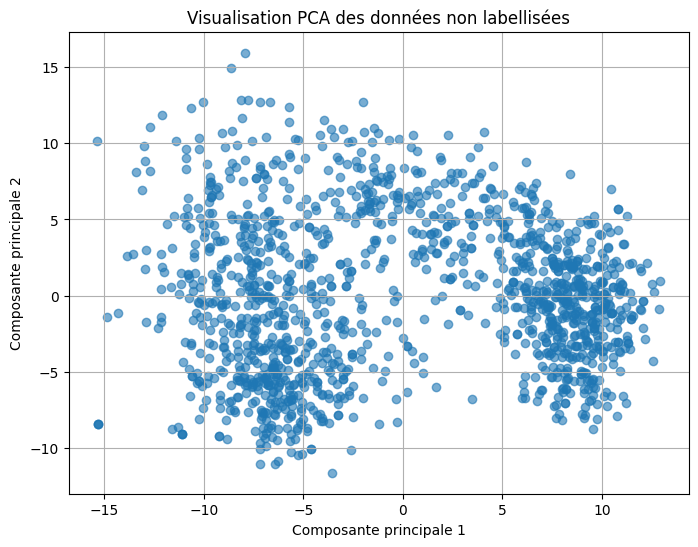

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_unlabeled[:, 0], X_pca_unlabeled[:, 1], alpha=0.6)
plt.title("Visualisation PCA des données non labellisées")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

Avec notre ResNet18 sur l'avant dernière couche on voit une séparation entre nos données. Le modèle encode des concepts moins élevés que l'avant-dernière couche du ResNet50 ce qui  permet un regroupement de sous-ensemble. Nous sommes dans un jeu non labellisé, alors la séparation n'est pas nette.


### Visualisation T-SNE

* Regardons une autre méthode de réduction des dimensions, T-SNE, un méthode non-linéaire. L'objectif du PCA étant de maximiser la variance, alors qu'ici l'objectif va être de préserver des similarités par paire entre les points de données.

In [7]:
tsne = TSNE(n_components = 2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_unlabeled_TSNE)
tsne.kl_divergence_ # t-SNE minimise une perte appelée KL divergence / C’est la valeur finale de la fonction de perte que t-SNE essaie de minimiser

0.9518011808395386

#### Regardons la visualisation

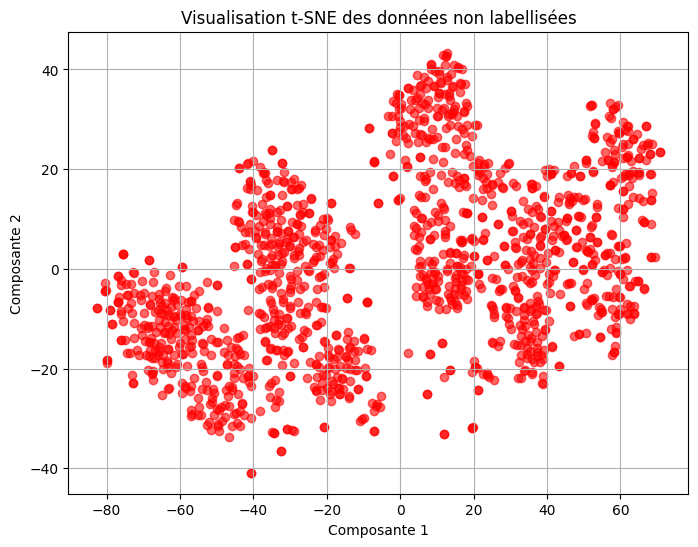

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, color="red")
plt.title("Visualisation t-SNE des données non labellisées")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.grid(True)
plt.show()

* Le t-SNE arrive à nous donner deux sous-ensembles assez grossier, qui semblent eux même découpés en petit cluster. Il arrive à regrouper quelques similarités en groupe mais cela reste un peu confus.

## Sur le layer3 du ResNet18

#### On commence par normaliser nos données afin que chaque caractéristique puisse avoir une variance égale à 1.

In [9]:
scaler = StandardScaler() # notre fonction de normalisation
scaler.fit(X_unlabeled_layer3) # nous entraînons le scaler sur le jeu de données
X_scaled_unlabeled_layer = scaler.transform(X_unlabeled_layer3) # application de la rotation et la réduction de la dimension avec transform
X_scaled_unlabeled_layer_PCA = X_scaled_unlabeled_layer # Préparation pour le PCA
X_scaled_unlabeled_layer_TSNE = X_scaled_unlabeled_layer # Préparation pour le t-SNE

#### Application du PCA pour réduire la dimensionnalité

In [10]:
pca = PCA(n_components=2) # nombre de composantes principales que nous voulons afficher
pca.fit(X_scaled_unlabeled_layer_PCA) # on fait tourner notre PCA

X_pca_unlabeled_layer = pca.transform(X_scaled_unlabeled_layer_PCA)
print("Original shape: {}".format(str(X_scaled_unlabeled_layer_PCA.shape)))
print("Reduced shape : {}".format(str(X_pca_unlabeled_layer.shape)))

Original shape: (1406, 256)
Reduced shape : (1406, 2)


#### Traçons les deux composantes principales 

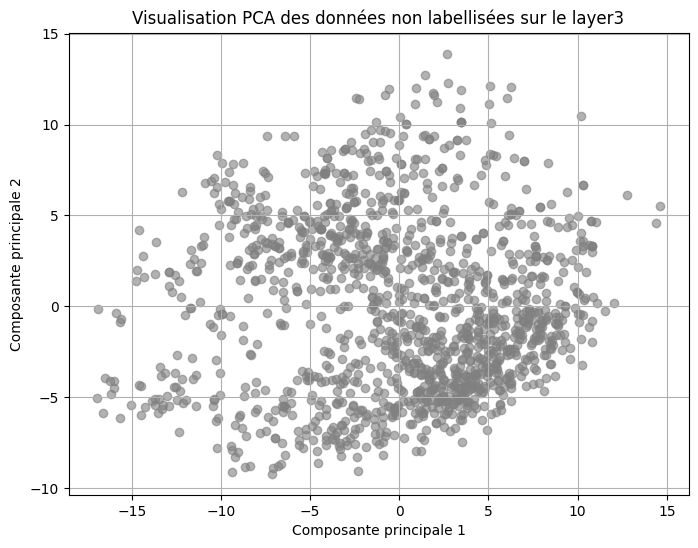

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_unlabeled_layer[:, 0], X_pca_unlabeled_layer[:, 1], alpha=0.6, color="grey")
plt.title("Visualisation PCA des données non labellisées sur le layer3")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

* En prenant l'extraction des features sur une couche plus proche, on ne voit pas une amélioration par rapport à l'avant dernière couche, on peut distinguer deux sous-ensembles mais ils sont moins séparés, il y a une masse un peu plus compact au milieu et c'est un peu plus diffus.

### Visualisation T-SNE

* Regardons une autre méthode de réduction des dimensions, T-SNE, un méthode non-linéaire. L'objectif du PCA étant de maximiser la variance, alors qu'ici l'objectif va être de préserver des similarités par paire entre les points de données.

In [12]:
tsne = TSNE(n_components = 2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_unlabeled_layer_TSNE)
tsne.kl_divergence_ # t-SNE minimise une perte appelée KL divergence / C’est la valeur finale de la fonction de perte que t-SNE essaie de minimiser

0.7340600490570068

#### Regardons la visualisation

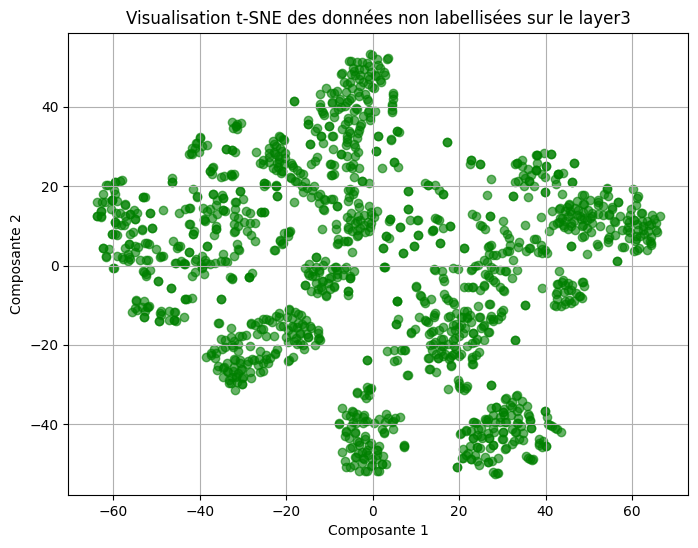

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, color="green")
plt.title("Visualisation t-SNE des données non labellisées sur le layer3")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.grid(True)
plt.show()

* Il y a plusieurs clusters nets, on voit des amas compacts, vraiment séparés les uns des autres. Les features de layer3 contiennent une structure interne riche. Elles discriminent différents types de motifs présents dans les images.

## Clustering - K-Means sur l'avant dernière couche
* Nous allons déjà tester la méthode des k-means.
* Toujours sur nos données non labellisées.

#### Nous devons normaliser (nous l'avons déjà fait) et effectuer de nouveau un PCA sur tout le DataFrame mais cette fois nous allons prendre plus de composantes en compte car l'objectif du PCA n'est pas la visualisation ici.

In [9]:
X_scaled_kmeans = X_scaled_unlabeled
pca = PCA(n_components=50) # nombre de composantes principales que nous voulons afficher
pca.fit(X_scaled_kmeans) # on fait tourner notre PCA

X_unlabeled_kmeans = pca.transform(X_scaled_kmeans)
print("Original shape: {}".format(str(X_scaled_kmeans.shape)))
print("Reduced shape : {}".format(str(X_unlabeled_kmeans.shape)))

Original shape: (1406, 512)
Reduced shape : (1406, 50)


* On note bien la réduction du nombre de caractéristiques de 512 à 50 et on constate que nous avons bien notre jeu non labellisé de 1406 lignes.

#### Fonction K-Means

In [10]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_unlabeled_kmeans)
print("Cluster :\n{}".format(kmeans.labels_))

Cluster :
[1 1 0 ... 0 1 1]


#### Enregistrement des pseudos labels

In [11]:
pseudo_label = kmeans.labels_
pd.DataFrame({
  "filename": df_unlabeled["filename"],
  "pseudo_label": pseudo_label
}).to_csv("../data/processed/pseudo_labels.csv", index=False)

### Scatter Plot de PC0 et PC1

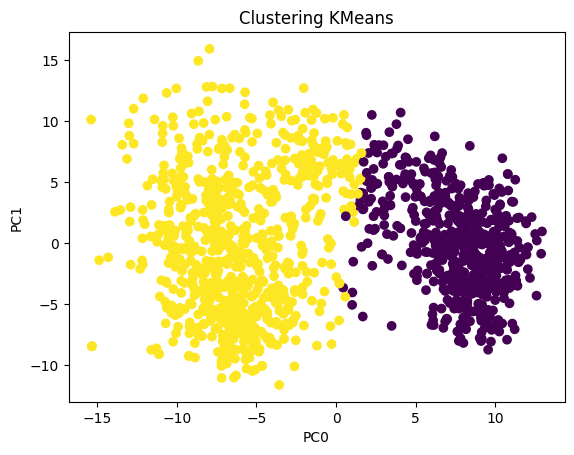

In [12]:
plt.scatter(X_unlabeled_kmeans[:, 0], X_unlabeled_kmeans[:, 1], c=kmeans.labels_, cmap="viridis")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("Clustering KMeans")
plt.show()


* k-means arrive à identifier correctement les 2 clusters demandés, même si elle n'est pas parfaite, on voit qu'une séparation des données n'est pas loin, la masse à gauche est un peu dispersée mais de manière contrôlée.

#### Regardons avec un pairplot sur les premières composantes

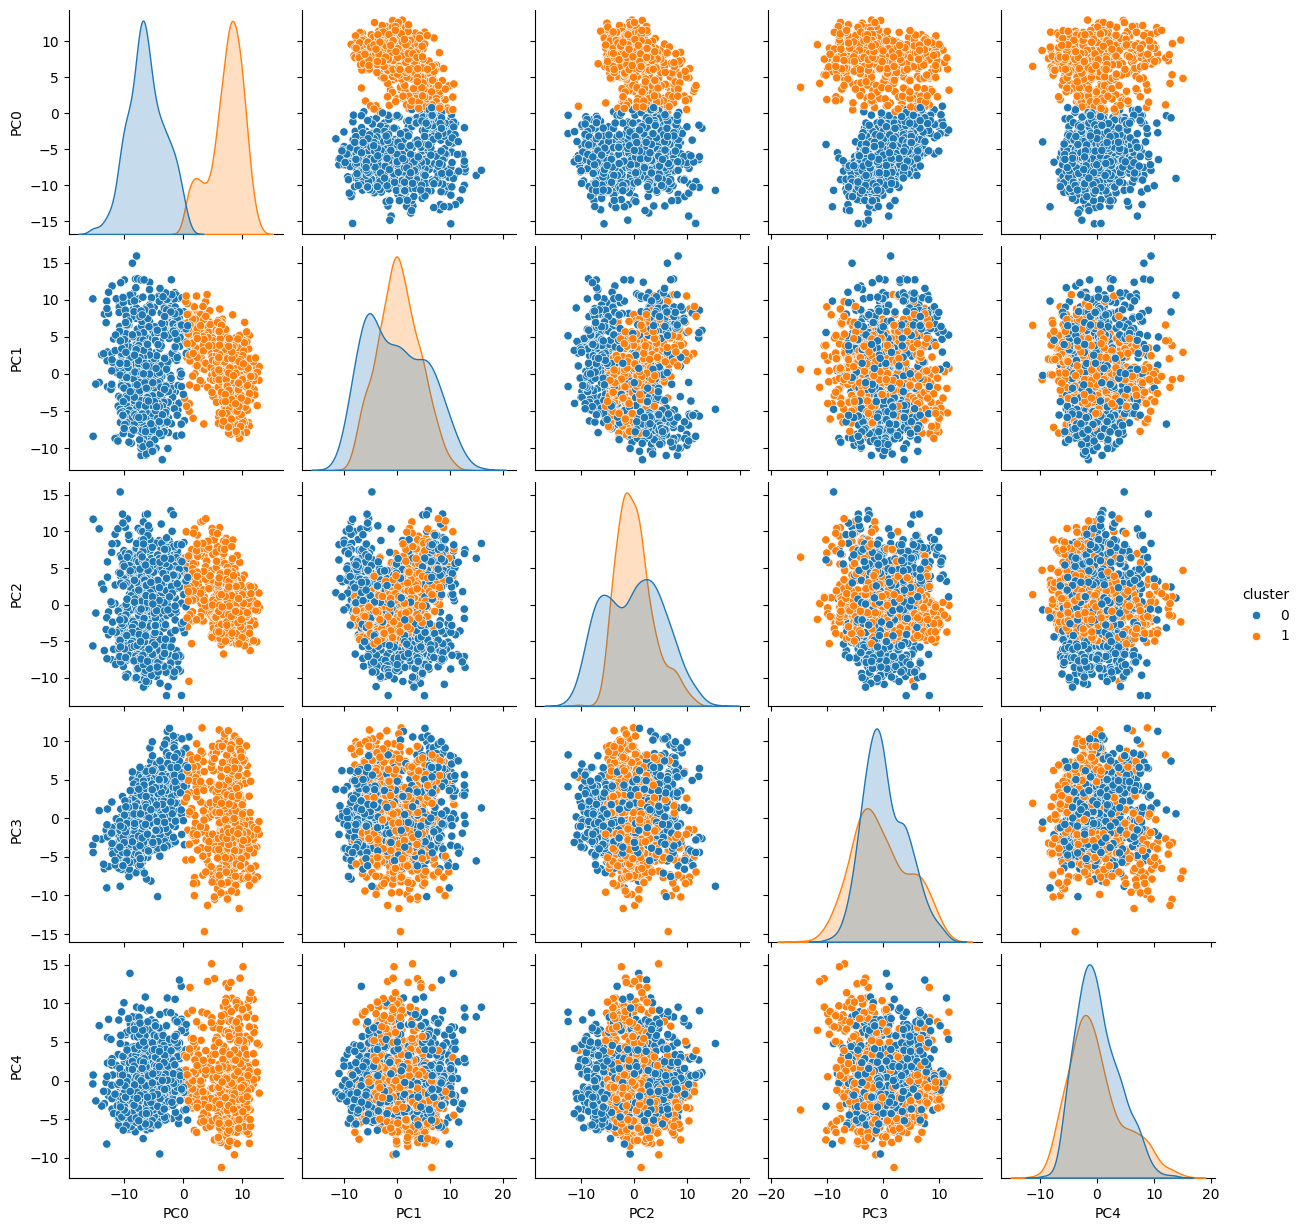

In [17]:
df_plot = pd.DataFrame(X_unlabeled_kmeans[:, :5], columns=[f"PC{i}" for i in range(5)])
df_plot["cluster"] = kmeans.labels_

sns.pairplot(df_plot, hue="cluster")


* On voit nettement l'importance de PC0 qui sépare "correctement" notre jeu de donnée.

## Clustering - K-Means sur le layer 3

#### Nous devons normaliser (nous l'avons déjà fait) et effectuer de nouveau un PCA sur tout le DataFrame mais cette fois nous allons prendre plus de composantes en compte car l'objectif du PCA n'est pas la visualisation ici.

In [18]:
X_scaled_kmeans_layer = X_scaled_unlabeled_layer
pca = PCA(n_components=50) # nombre de composantes principales que nous voulons afficher
pca.fit(X_scaled_kmeans_layer) # on fait tourner notre PCA

X_unlabeled_kmeans_layer = pca.transform(X_scaled_kmeans_layer)
print("Original shape: {}".format(str(X_scaled_kmeans_layer.shape)))
print("Reduced shape : {}".format(str(X_unlabeled_kmeans_layer.shape)))

Original shape: (1406, 256)
Reduced shape : (1406, 50)


#### Fonction K-Means

In [19]:
kmeans_layer = KMeans(n_clusters=2, random_state=42)
kmeans_layer.fit(X_unlabeled_kmeans_layer)
print("Cluster :\n{}".format(kmeans_layer.labels_))

Cluster :
[1 0 0 ... 1 0 0]


#### Visualisation k-means

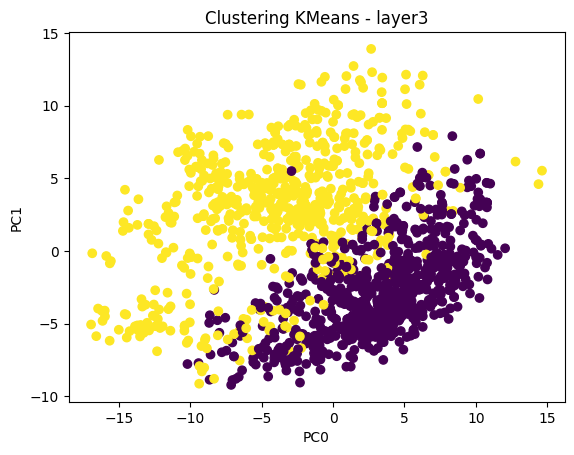

In [20]:
plt.scatter(X_unlabeled_kmeans_layer[:, 0], X_unlabeled_kmeans_layer[:, 1], c=kmeans.labels_, cmap="viridis")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("Clustering KMeans - layer3")
plt.show()

* La séparation entre les clusters n'est pas nette et sont un peu mélangés, et le jeu semble un peu plus répandu que l'autre k-means et un peu plus diffu

#### Regardons avec un pairplot sur les premières composantes

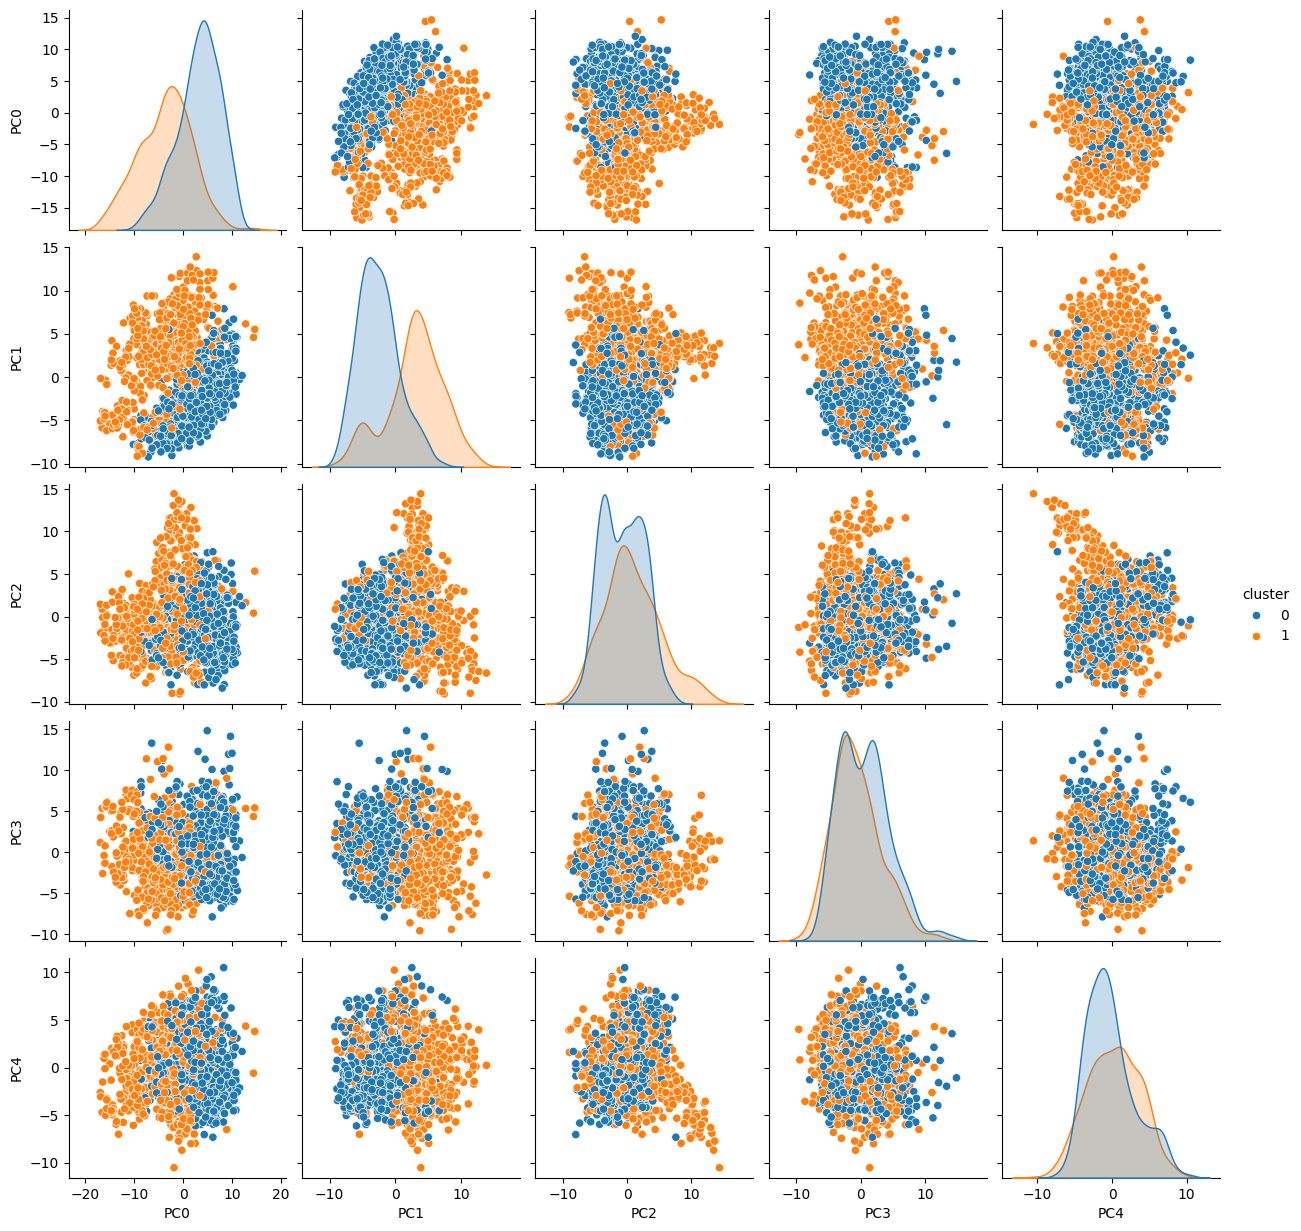

In [21]:
df_plot = pd.DataFrame(X_unlabeled_kmeans_layer[:, :5], columns=[f"PC{i}" for i in range(5)])
df_plot["cluster"] = kmeans.labels_

sns.pairplot(df_plot, hue="cluster")


* On note bien la distinction avec PC0, la séparation n'est pas claire mais on identifie bien 2 groupes et qui sont assez regroupés.

## Méthode DBScan

- L'algorithme fonctionne en définissant les grappes comme des régions denses séparées par des régions de moindre densité. Cette approche permet à DBSCAN de découvrir des grappes de forme arbitraire et d'identifier les valeurs aberrantes comme du bruit.

- DBSCAN s'articule autour de trois concepts clés :

* Points essentiels: Il s'agit de points qui ont au moins un nombre minimum d'autres points (MinPts) à une distance spécifiée (ε ou epsilon).
* Points frontières: Il s'agit de points qui se trouvent à une distance ε d'un point central mais qui n'ont pas de MinPts voisins eux-mêmes.
* Points de bruit: Il s'agit de points qui ne sont ni des points centraux ni des points frontières. Ils ne sont pas assez proches d'un groupe pour être inclus.

### ResNet50 avant-dernière couche

#### On récupère notre DataFrame et notre pipeline déjà normalisé

In [22]:
X_scaled_dbscan = X_scaled_unlabeled
pca = PCA(n_components=50) # nombre de composantes principales que nous voulons afficher
pca.fit(X_scaled_dbscan) # on fait tourner notre PCA

X_unlabeled_dbscan = pca.transform(X_scaled_dbscan)
print("Original shape: {}".format(str(X_scaled_dbscan.shape)))
print("Reduced shape : {}".format(str(X_unlabeled_dbscan.shape)))

Original shape: (1406, 512)
Reduced shape : (1406, 50)


#### On calcul notre point epsilon en fonction du graphique k distance

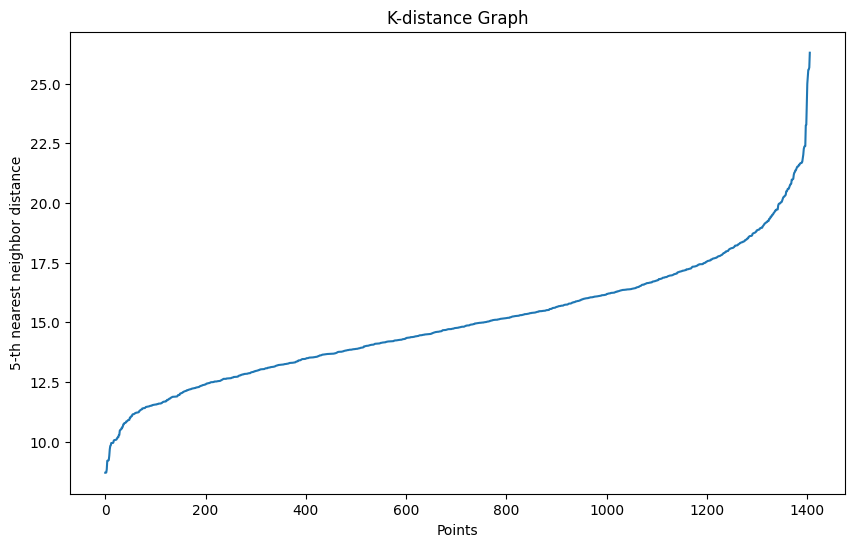

In [23]:
# Fonction du grpahique k distance
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
# Graph
plot_k_distance_graph(X_unlabeled_dbscan, k=5)

In [24]:
dbscan = DBSCAN(eps=20, min_samples=5)
clusters = dbscan.fit_predict(X_unlabeled_dbscan)
print("Cluster :\n {}".format(clusters))

Cluster :
 [0 0 0 ... 0 0 0]


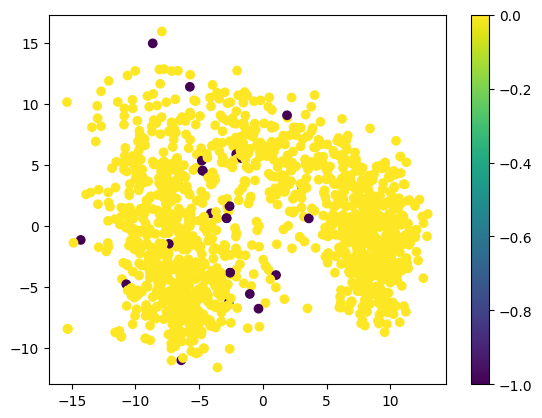

In [25]:
# Visualisation
plt.scatter(X_unlabeled_dbscan[:,0], X_unlabeled_dbscan[:,1], c=clusters, cmap="viridis")
plt.colorbar()
plt.show()

Après normalisation et réduction PCA à 50 dimensions, l’algorithme DBSCAN ne parvient pas à séparer les données en deux clusters distincts.
Le graphique des k-distances ne présente pas de coude net, ce qui indique l’absence de régions densément séparées.
DBSCAN détecte donc un seul cluster principal et quelques points considérés comme du bruit.
Cette observation confirme que la séparation naturelle du dataset est linéaire (bien capturée par KMeans), mais ne repose pas sur des variations locales de densité. DBSCAN n'est donc pas adapté pour ce jeu de données.

### ResNet50 sur layer3

In [24]:
X_scaled_dbscan = X_scaled_unlabeled_layer
pca = PCA(n_components=50) # nombre de composantes principales que nous voulons afficher
pca.fit(X_scaled_dbscan) # on fait tourner notre PCA

X_unlabeled_dbscan = pca.transform(X_scaled_dbscan)
print("Original shape: {}".format(str(X_scaled_dbscan.shape)))
print("Reduced shape : {}".format(str(X_unlabeled_dbscan.shape)))

Original shape: (1406, 256)
Reduced shape : (1406, 50)


#### On calcul notre point epsilon en fonction du graphique k distance

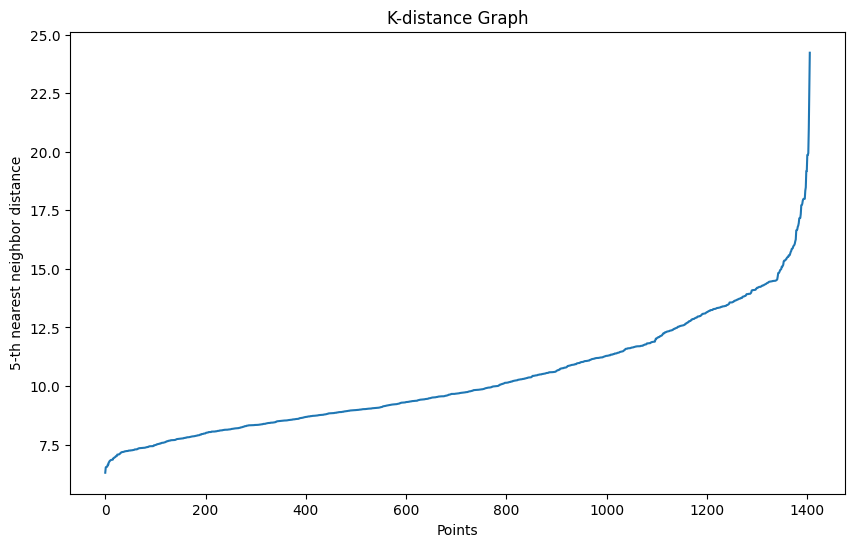

In [25]:
# Fonction du grpahique k distance
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.show()
# Graph
plot_k_distance_graph(X_unlabeled_dbscan, k=5)

In [28]:
dbscan = DBSCAN(eps=16, min_samples=5)
clusters = dbscan.fit_predict(X_unlabeled_dbscan)
print("Cluster :\n {}".format(clusters))

Cluster :
 [0 0 0 ... 0 0 0]


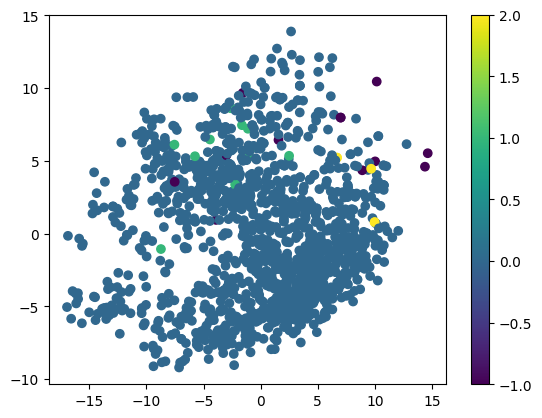

In [29]:
# Visualisation
plt.scatter(X_unlabeled_dbscan[:,0], X_unlabeled_dbscan[:,1], c=clusters, cmap="viridis")
plt.colorbar()
plt.show()

Après normalisation et réduction PCA à 50 dimensions, l’algorithme DBSCAN ne parvient pas à séparer les données en deux clusters distincts.
Le graphique des k-distances ne présente pas de coude net, ce qui indique l’absence de régions densément séparées.
DBSCAN détecte donc un seul cluster principal et quelques points considérés comme du bruit.
Cette observation confirme que la séparation naturelle du dataset est linéaire (bien capturée par KMeans), mais ne repose pas sur des variations locales de densité. DBSCAN n'est donc pas adapté pour ce jeu de données.

## Calcul du score ARI
* L'ARI mesure à quel point "les clusters naturels" correspondent aux "labels humains"

#### Avant-dernière couche

In [13]:
X_labeled = df_labeled.drop(columns = ["label","filename"])
y_labeled = df_labeled["label"]

scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)

pca = PCA(n_components=50) # nombre de composantes principales que nous voulons afficher
pca.fit(X_labeled_scaled) # on fait tourner notre PCA

X_pca_k_means = pca.transform(X_labeled_scaled)
X_pca_dbscan = pca.transform(X_labeled_scaled)

# Clustering KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca_k_means)

# Clustering DBSCAN
dbscan = DBSCAN(eps=20, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca_dbscan)

# ARI
ari_kmeans = adjusted_rand_score(y_labeled, kmeans_labels)
ari_dbscan = adjusted_rand_score(y_labeled, dbscan_labels)

print("ARI KMeans :", ari_kmeans)
print("ARI DBSCAN :", ari_dbscan)


ARI KMeans : 0.37868895911917627
ARI DBSCAN : 0.24259734536744995


* L’ARI obtenu avec KMeans montre que l'avant dernière couche est adapté à notre jeu et va chercher les bons motifs visuels.
* DBSCAN obtient un ARI plus faible (environ 0.28), ce qui confirme que les données ne comportent pas de régions densément séparées, rendant l’approche basée sur la densité inadaptée.

#### Sur le layer3

In [32]:
X_labeled = df_labeled_layer3.drop(columns = "label")
y_labeled = df_labeled_layer3["label"]

scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)

pca = PCA(n_components=50) # nombre de composantes principales que nous voulons afficher
pca.fit(X_labeled_scaled) # on fait tourner notre PCA

X_pca_k_means = pca.transform(X_labeled_scaled)
X_pca_dbscan = pca.transform(X_labeled_scaled)

# Clustering KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca_k_means)

# Clustering DBSCAN
dbscan = DBSCAN(eps=16, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca_dbscan)

# ARI
ari_kmeans = adjusted_rand_score(y_labeled, kmeans_labels)
ari_dbscan = adjusted_rand_score(y_labeled, dbscan_labels)

print("ARI KMeans :", ari_kmeans)
print("ARI DBSCAN :", ari_dbscan)

ARI KMeans : 0.4572332996116568
ARI DBSCAN : 0.049535452322738385


* L’ARI obtenu avec KMeans (environ 0.46) montre également une bonne adaptation à nos images. Le score est très proche de la version de l'avant-dernière couche mais cette dernière obtient un meilleur ARI.
* DBSCAN obtient un ARI très faible (environ 0.05), ce qui confirme que les données ne comportent pas de régions densément séparées, rendant l’approche basée sur la densité inadaptée.

* En résumé, le clustering capture une partie, mais pas l’intégralité, de la structure liée aux labels médicaux, ce qui peut être normal avec des données complexes d’IRM et une approche non supervisée. Mais la version avec le ResNet18 semble mieux s'adapter pour notre projet.